# Validate the flatness-based trajectory generation for car-like robots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mrobotics.motion_planning.car_kinematic import tg_ackermann_flatness

In [2]:
wheelbase = 1.8

# here we will do closed-loop control for following a
traj_generator = tg_ackermann_flatness(wheelbase=wheelbase,prediction_horizon=5.0)

initial_pose = np.array([0.0, 0.0, np.pi/3]) 
initial_yaw = initial_pose[-1] # the flatness representation has a SIGN ambiguity!
initial_speed = 1.0 # m/s 
initial_vel = initial_speed * np.array([np.cos(initial_yaw), np.sin(initial_yaw)]) # *-1 if we want  
traj_generator.update_flat_traj(p0=initial_pose[:2],v0=initial_vel,pf=[-0.5,3.5],vf=initial_vel)
# initial state 0,0, np.pi/2
# [0,0], [1,0], [5,1.2], [1,0]

In [3]:
t_eval = np.linspace(0,traj_generator.flat_traj_rep.T,100+1)
X_fwd, U_fwd = traj_generator.compute_traj_x_u(t_eval, vel_positive=True)
X_rev, U_rev = traj_generator.compute_traj_x_u(t_eval, vel_positive=False) # FYI

## The trajectory of the car position

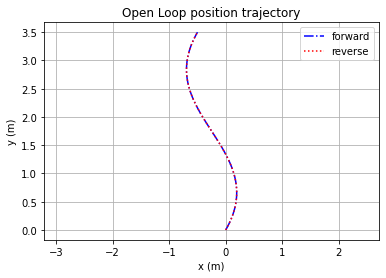

In [4]:
plt.plot(X_fwd[:,0],X_fwd[:,1], '-.b',label='forward') 
plt.plot(X_rev[:,0],X_rev[:,1], ':r',label='reverse')
plt.axis('equal')
plt.grid('major')
plt.legend()
plt.title('Open Loop position trajectory')
plt.xlabel('x (m)'); plt.ylabel('y (m)')
plt.show()

## Inspect the actuator dynamics

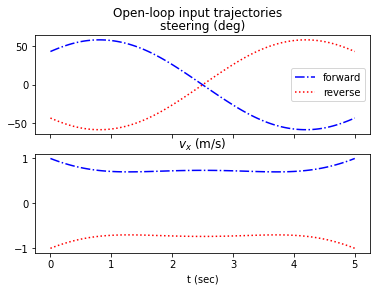

In [5]:
_, axs = plt.subplots(2,1,sharex=True)
plt.suptitle('Open-loop input trajectories')

axs[0].plot(t_eval, U_fwd[:,0]*180/np.pi, '-.b',label='forward') 
axs[0].plot(t_eval, U_rev[:,0]*180/np.pi, ':r',label='reverse')
axs[0].set_title('steering (deg)')
axs[0].legend()

axs[1].plot(t_eval, U_fwd[:,1], '-.b',label='forward') 
axs[1].plot(t_eval, U_rev[:,1], ':r',label='reverse')
axs[1].set_title('$v_x$ (m/s)')
axs[1].set_xlabel('t (sec)')
plt.show()

Notice that the speed is not exactly constant.

## Do we need feedback?

What the flatness-based trajectory generator assumes
* negligible actuator dynamics
* analog control
* negligible slip
* ...

Let's see how bad it can get when each actuator has a (first-order) lag and the control is discretized with ZOH.

(bottom line: the initial pose matches with the one used for generating the flatness trajectory)

We will only focus on the forward driving case.

In [6]:
from mrobotics.models.motion.simulator import kinematic_car_simulator
plant_simulator = kinematic_car_simulator(
    step_sz=0.02, sim_duration=traj_generator.flat_traj_rep.T, 
    # initially the steering angle is on the wrong way
    initial_state=np.array([*initial_pose, -np.pi/10, +initial_speed*0.8]), 
#     initial_state=np.array([*initial_pose, -np.pi/4, 0.0]),  # <--- looking bad
    wheelbase=wheelbase, tau_steering=0.1, tau_vx=0.5
)

In [7]:
def open_loop_control(sim_time):
    _, U = traj_generator.compute_traj_x_u(sim_time)
    steering_angle_cmd, vx_cmd = U.T
    return float(steering_angle_cmd), float(vx_cmd)

In [8]:
while not plant_simulator.is_completed():
    sim_time = plant_simulator.get_current_time()
    steering_angle_cmd, vx_cmd = open_loop_control(sim_time)
    #--------------------------
    # must be called at the end of each step
    plant_simulator.step_actuate(steering_angle_cmd, vx_cmd)

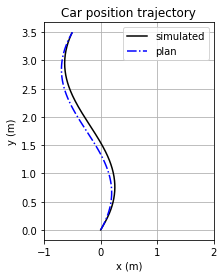

In [9]:
_,ax = plt.subplots()
plant_simulator.viz_pose(ax=ax)
plt.plot(X_fwd[:,0],X_fwd[:,1], '-.b',label='plan') 
ax.legend()
ax.set_xlim([-1.0, 2.0])
plt.show()

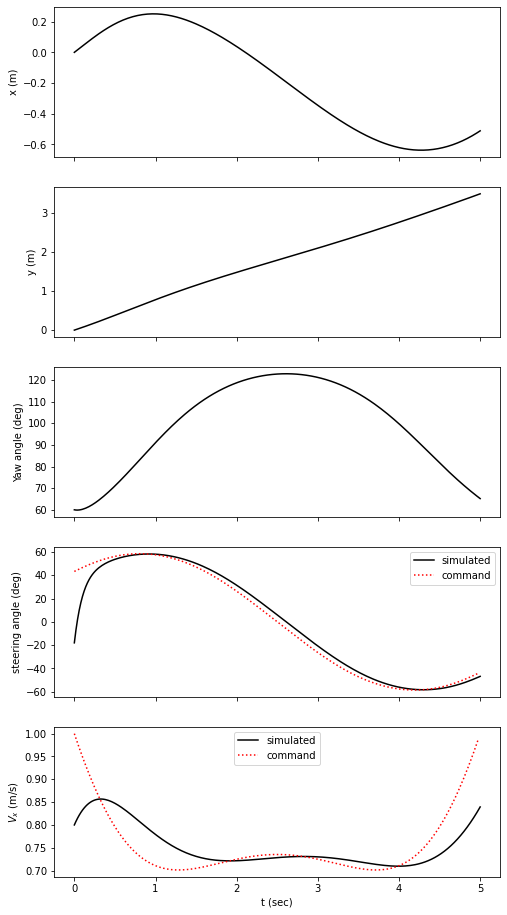

In [10]:
fig, axs = plt.subplots(5,1, sharex=True, figsize=(8,16))
plant_simulator.viz_trace(axs)
plt.show()

If the simulation model is representative enough (note that measurement noise, which we don't simulate, is irrelevant for any open-loop control), 
the open loop control looks acceptable in our test case.
However, we are just lucky. Most likely, you will see a different picture if you try to ...
* simulate with another initial state while keeping the offline trajectory unchanged (see the line with comment `looking bad`) and/or
* plan an offline (feasible) trajectory for a **longer** horizon 

In practice, we can apply feedback in form of trajectory tracker to "properly" execute the offline plan.

Another feedback approach can be re-generating the trajectory, say at regular "replanning" time interval (basically the same idea as MPC, although here we don't have any optimization under the hood).
This might lead to improved system performance (which hasn't been defined yet ^.^) 
Replanning is more involved (How shall we "shape" the trajectory? For that we really need to clarify the intented behavior, e.g. changing lane in our example) so we shall leave for another day.

Both feedback approaches can be combined together.